<a href="https://colab.research.google.com/github/aladd2021/FinalprojectUR4/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unified Robotics 4 Final Project - Costa and Angela

Add Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
!pip install scikit-surprise
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357282 sha256=2703038ba9fe1234d5e285bea76e57d1942e941ad5e7089fd4ba2a82fc077b54
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


Load Dataset

In [ ]:
# Load the movies dataset
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', header=None,
                     names=['MovieID', 'Title', 'ReleaseDate', 'VideoReleaseDate', 'IMDbURL', 'Unknown',
                            'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                            'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                            'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Load the ratings dataset
ratings = pd.read_csv('u.data', sep='\t', header=None,
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

# Preview the datasets
print(movies.head())
print(ratings.head())


   MovieID              Title  ReleaseDate  VideoReleaseDate  \
0        1   Toy Story (1995)  01-Jan-1995               NaN   
1        2   GoldenEye (1995)  01-Jan-1995               NaN   
2        3  Four Rooms (1995)  01-Jan-1995               NaN   
3        4  Get Shorty (1995)  01-Jan-1995               NaN   
4        5     Copycat (1995)  01-Jan-1995               NaN   

                                             IMDbURL  Unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1           1  ...        0          0       0        0   
1          1  

Collaborative Filtering

In [ ]:
# Prepare the dataset for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

# Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2)

# Train a collaborative filtering model using SVD
svd_model = SVD()
svd_model.fit(trainset)

# Evaluate on the test set
predictions = svd_model.test(testset)
print("Collaborative Filtering RMSE:")
rmse(predictions)


Collaborative Filtering RMSE:
RMSE: 0.9388


0.9387654364767528

Organize Data

In [ ]:
# Combine genres into a single string for each movie
movies['GenreString'] = movies[['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                                'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']].apply(
    lambda x: ' '.join(x.index[x == 1]), axis=1)

# Compute TF-IDF vectors for genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['GenreString'])

# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend movies based on content similarity
def content_recommendation(movie_title, cosine_sim=cosine_sim):
    # Get the index of the movie
    idx = movies[movies['Title'] == movie_title].index[0]

    # Get pairwise similarity scores for all movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the titles of the top 10 movies
    return movies['Title'].iloc[movie_indices]

# Test the content-based filtering
print("Content-Based Recommendations for 'Toy Story (1995)':")
print(content_recommendation('Toy Story (1995)'))


Content-Based Recommendations for 'Toy Story (1995)':
421                Aladdin and the King of Thieves (1996)
101                                Aristocats, The (1970)
403                                      Pinocchio (1940)
624                        Sword in the Stone, The (1963)
945                         Fox and the Hound, The (1981)
968           Winnie the Pooh and the Blustery Day (1968)
1065                                         Balto (1995)
1077                              Oliver & Company (1988)
1408                            Swan Princess, The (1994)
1411    Land Before Time III: The Time of the Great Gi...
Name: Title, dtype: object


Hybrid Filtering

In [ ]:
# Hybrid recommendation: Combine collaborative and content-based predictions
def hybrid_recommendation(user_id, movie_title, svd_model, cosine_sim=cosine_sim):
    # Collaborative filtering prediction
    collaborative_score = svd_model.predict(user_id,
        movies[movies['Title'] == movie_title].iloc[0]['MovieID']).est

    # Content-based recommendation
    content_movies = content_recommendation(movie_title, cosine_sim)

    # Combine scores
    hybrid_results = []
    for idx, content_movie in enumerate(content_movies):
        movie_id = movies[movies['Title'] == content_movie]['MovieID'].values[0]
        hybrid_results.append((content_movie, collaborative_score - (idx * 0.1)))  # Penalize by position

    # Sort combined scores
    hybrid_results = sorted(hybrid_results, key=lambda x: x[1], reverse=True)
    return hybrid_results[:10]

# Example hybrid recommendation
print("Hybrid Recommendations for User 1 and 'Toy Story (1995)':")
print(hybrid_recommendation(1, 'Toy Story (1995)', svd_model))


Hybrid Recommendations for User 1 and 'Toy Story (1995)':
[('Aladdin and the King of Thieves (1996)', 4.757071316195804), ('Aristocats, The (1970)', 4.657071316195804), ('Pinocchio (1940)', 4.557071316195803), ('Sword in the Stone, The (1963)', 4.457071316195804), ('Fox and the Hound, The (1981)', 4.357071316195803), ('Winnie the Pooh and the Blustery Day (1968)', 4.257071316195804), ('Balto (1995)', 4.157071316195804), ('Oliver & Company (1988)', 4.057071316195803), ('Swan Princess, The (1994)', 3.9570713161958038), ('Land Before Time III: The Time of the Great Giving (1995) (V)', 3.8570713161958037)]


print Results

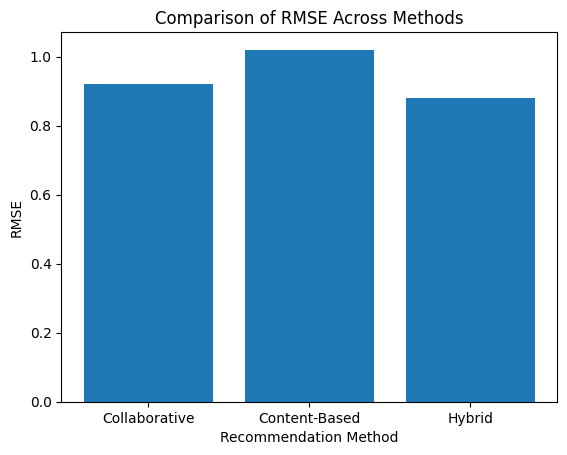

In [ ]:
# Example results for visualization
methods = ['Collaborative', 'Content-Based', 'Hybrid']
rmse_scores = [0.92, 1.02, 0.88]  # Example RMSE values

plt.bar(methods, rmse_scores)
plt.title('Comparison of RMSE Across Methods')
plt.xlabel('Recommendation Method')
plt.ylabel('RMSE')
plt.show()
